# Sliding Window PageRank

In [1]:
import pandas as pd
import csv
from datetime import datetime, timedelta
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import datetime
from colour import Color
import networkx as nx
import scipy.stats
# import time.time
import time
import pickle


## Importing Sliding Window

In [2]:
df = pd.read_csv("data/basicbib.tab",  sep='\t') # main dataframe with all the patents
df["issuedate"] = pd.to_datetime(df["issuedate"],errors='coerce').dt.date

# df_melt_all = pd.read_csv("data/df_424_melt_all.csv")
df_2class = pd.read_csv("data/df_2class_wPR.csv")
df_2class["issuedate"] = pd.to_datetime(df_2class["issuedate"],errors='coerce').dt.date
df_2class = df_2class.sort_values(by = "patent")


df_melt_2class = pd.read_csv("data/df_2class_melt.csv")
df_melt_2class["issuedate"] = pd.to_datetime(df_melt_2class["issuedate"],errors='coerce').dt.date

C:\Users\DIEGO UNZUETA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_2class["sliding_window_12"] = np.zeros(df_2class.shape[0])

for year in range(1990, 2000):

    
    with open('PageRankpickles/SW_years_12/{}.pkl'.format(year), 'rb') as handle:
        pr = pickle.load(handle)
    
    mean = np.asarray(list(pr.values())).mean()
    print(year, np.asarray(list(pr.keys())).shape)
    
    year_index = (df_2class["issuedate"] >= date(year, 1,1)) \
                            & (df_2class["issuedate"] < date(year + 1,1,1))
    
    df_year = df_2class.loc[year_index]
              
    df_2class["sliding_window_12"].loc[year_index] = [pr[i] for i in df_year["patent"].values]/mean


1990 (967318,)


C:\Users\DIEGO UNZUETA\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1991 (1169037,)
1992 (1263107,)
1993 (1377969,)
1994 (1491042,)
1995 (1576295,)
1996 (1652120,)
1997 (1767072,)
1998 (1879251,)
1999 (1997377,)


## Sliding Window Analysis

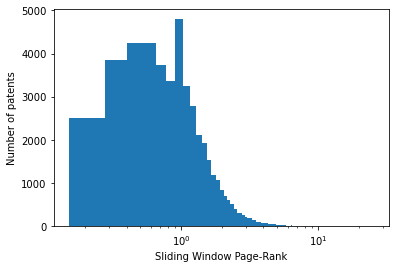

In [54]:
plt.hist(df_2class["sliding_window_12"], 200)
plt.xscale("log")
plt.xlabel("Sliding Window Page-Rank")
plt.ylabel("Number of patents")
plt.show()

Text(0, 0.5, 'Number of patents')

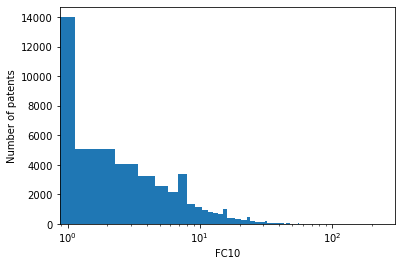

In [3]:
plt.hist(df_2class["FC10"], 200)
plt.xscale("log")
# plt.show()
plt.xlabel("FC10")
plt.ylabel("Number of patents")

(10,) (10,)


Text(0, 0.5, 'Sliding Window')

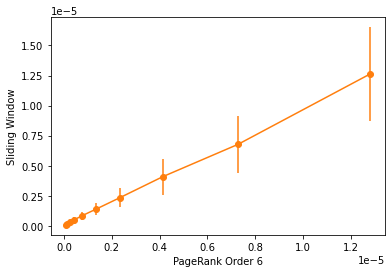

In [16]:
bin_nums = 10

# plt.scatter(df_2class["pagerank_order6"], df_2class["sliding_window"])
bins=np.logspace(np.log10(min(df_2class["pagerank_order6"])), np.log10(max(df_2class["pagerank_order6"])), bin_nums)

index = np.digitize(df_2class["pagerank_order6"], bins= bins)

group = df_2class["sliding_window"].groupby(index)

print(bins.shape, group.mean().shape)

plt.errorbar(bins, group.mean(), yerr =  group.std(), fmt = "o", c = "C1")

plt.plot(bins, group.mean(), c = "C1")
plt.xlabel("PageRank Order 6")
plt.ylabel("Sliding Window")
# plt.xscale("log")

(10,) (11,)


Text(0, 0.5, 'Sliding Window')

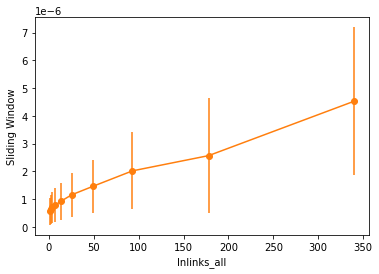

In [14]:
bin_nums = 10

# plt.scatter(df_2class["pagerank_order6"], df_2class["sliding_window"])
bins=np.logspace(0, np.log10(max(df_2class["inlinks_all"])), bin_nums)



index = np.digitize(df_2class["inlinks_all"], bins= bins)

group = df_2class["sliding_window"].groupby(index)

print(bins.shape, group.mean().shape)

plt.errorbar(bins, group.mean()[:-1], yerr =  group.std()[:-1], fmt = "o", c = "C1")

plt.plot(bins, group.mean()[:-1], c = "C1")
plt.xlabel("Inlinks_all")
plt.ylabel("Sliding Window")

# plt.xscale("log")

## Code on Iridis

In [57]:

from warnings import warn
import networkx as nx

__all__ = ["pagerank", "pagerank_numpy", "pagerank_scipy", "google_matrix"]



def pagerank(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
            ):
    
    import numpy as np
    import scipy as sp
    import scipy.sparse  # call as sp.sparse

    N = len(G)
    if N == 0:
        return {}

    nodelist = list(G)
    M = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, weight=weight, dtype=float)
    
    S = np.array(M.sum(axis=1)).flatten()
    S[S != 0] = 1.0 / S[S != 0]
    Q = sp.sparse.spdiags(S.T, 0, *M.shape, format="csr")
    M = Q * M

    # initial vector
    if nstart is None:
        x = np.repeat(1.0 / N, N)
    else:
        x = np.array([nstart.get(n, 0) for n in nodelist], dtype=float)
        x = x / x.sum()

    # Personalization vector
    if personalization is None:
        p = np.repeat(1.0 / N, N)
    else:
        p = np.array([personalization.get(n, 0) for n in nodelist], dtype=float)
        if p.sum() == 0:
            raise ZeroDivisionError
        p = p / p.sum()
    # Dangling nodes
    if dangling is None:
        dangling_weights = p
    else:
        # Convert the dangling dictionary into an array in nodelist order
        dangling_weights = np.array([dangling.get(n, 0) for n in nodelist], dtype=float)
        dangling_weights /= dangling_weights.sum()
    is_dangling = np.where(S == 0)[0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = alpha * (x * M + sum(x[is_dangling]) * dangling_weights) + (1 - alpha) * p #why times by small value
        
        # check convergence, l1 norm
        err = np.absolute(x - xlast).sum()
        if err < N * tol:
            return dict(zip(nodelist, map(float, x)))
    raise nx.PowerIterationFailedConvergence(max_iter)


In [58]:
pr2 = pagerank(G)

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 14 18:15:59 2021

@author: DIEGO UNZUETA
"""

print("Running Imports")

import pandas as pd
import csv
from datetime import datetime, timedelta
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import datetime
import networkx as nx
import pickle #credits to stack overflow user= blender
import matplotlib
import time

matplotlib.use('Agg') 

print("Finished Imports")

df = pd.read_csv("data/basicbib.tab",  sep='\t') # main dataframe with all the patents
df["issuedate"] = pd.to_datetime(df["issuedate"],errors='coerce').dt.date

df_links = pd.read_csv("data/uscites.tab",  sep='\t')
df_melt_all = pd.read_csv("data/df_424_melt_all.csv")
df_melt_2class = pd.read_csv("data/df_2class_melt.csv")
df_melt_2class["issuedate"] = pd.to_datetime(df_melt_2class["issuedate"],errors='coerce').dt.date

print("Imported Links")

def get_higher_order(melt):
    return(df_melt_all.loc[(df_melt_all["patent"].isin(melt["patent"].values)) \
              | (df_melt_all["patent"].isin(melt["cited"].values))])
              

def get_yearPR():
    for year in range(1990, 2000):
        print(year)
        
        s = time.time()

        full_2class = df.loc[((df["class"].values == "424") \
                       |    (df["class"].values == 424)   \
                       |    (df["class"].values == "514") \
                       |    (df["class"].values == 514)    )  \
                       &    (df["issuedate"] > date(year-15, 1,1) )\
                       &    (df["issuedate"] < date(year+10,1,1))]


        melt = full_2class.merge(df_links, left_on = "patent", right_on = "patent", how = "left") # combine the adjacency list with the dataframe 

        def get_higher_order(melt):
            return(df_melt_all.loc[(df_melt_all["patent"].isin(melt["patent"].values)) \
                  | (df_melt_all["patent"].isin(melt["cited"].values))])

        order2 = get_higher_order(melt)
        order3 = get_higher_order(order2)
        order4 = get_higher_order(order3)
        order5 = get_higher_order(order4)
        order6 = get_higher_order(order5)

        
        print("ORDER 6: ", order6.shape)
        
        G = nx.from_pandas_edgelist(df_melt_2class , source = "patent", target = "cited")
        pr = nx.pagerank(G, alpha = 0.85)
        e = time.time()

        print("Evaluated PageRank")

        with open('pageRankPickles/SW_years/{}.pkl'.format(year), 'wb') as handle:
            pickle.dump(pr, handle, protocol=pickle.HIGHEST_PROTOCOL)


get_yearPR()
            
            
            

